In [1]:
import pickle
with open('/home/z5297792/UNSW-MRes/MRes/Climatology/ROMS_26yr_daydic.pkl', 'rb') as file:
    daydic = pickle.load(file)

with open('/home/z5297792/UNSW-MRes/MRes/Climatology/ROMS_26yr_eddies.pkl', 'rb') as file:
    eddies = pickle.load(file)

with open('/srv/scratch/z5297792/Sample/frontier_sample_data.pkl', 'rb') as file:
    sample_data = pickle.load(file)
the_frontier_eddies = list(sample_data.keys())

In [2]:
sample_data['Eddy790']['T0'].keys()

dict_keys(['U', 'V', 'x', 'y', 'z', 'VG', 'COW', 'LNAM', 'rho'])

In [3]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import time

fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho  = dataset.variables['lon_rho'][:]
lon_rho = np.transpose(lon_rho, axes=(1, 0))
lat_rho  = dataset.variables['lat_rho'][:]
lat_rho = np.transpose(lat_rho, axes=(1, 0))
z_r = np.load('/home/z5297792/UNSW-MRes/MRes/z_r/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))

import re
def extract_number(s):
    match = re.search(r'\d+', s)
    return int(match.group()) if match else None

In [4]:
def nencioli(u, v, lon, lat, a, b): #,var
    borders = max(a, b) + 1
    vel = np.sqrt(u**2 + v**2)
    eddy_uv, eddy_c, eddy = np.zeros((0, 2)), np.zeros((0, 2)), np.zeros((0, 3))
    bound = vel.shape
    for i in range(borders, len(v) - borders + 1):
        wrk = v[i, :]  # Latitudinal section of v
        s = np.sign(wrk)
        indx = np.where(np.diff(s) != 0)[0]
        indx = indx[(indx >= borders) & (indx < len(wrk) - borders)]
        for ii in indx:
            var = 0  # Eddy type (0 = no eddy, 1 = cyclonic, -1 = anticyclonic)
            if wrk[ii] >= 0:  # Anticyclonic
                if wrk[ii - a] > wrk[ii] and wrk[ii + 1 + a] < wrk[ii + 1]:
                    var = -1
            elif wrk[ii] < 0:  # Cyclonic
                if wrk[ii - a] < wrk[ii] and wrk[ii + 1 + a] > wrk[ii + 1]:
                    var = 1
            # Second constraint: u component reversal
            if var != 0:
                if var == -1:
                    if (u[i - a, ii] <= 0 and u[i - a, ii] <= u[i - 1, ii] and
                        u[i + a, ii] >= 0 and u[i + a, ii] >= u[i + 1, ii]):
                        eddy_uv = np.vstack([eddy_uv, [lat[i, ii], lon[i, ii]], [lat[i, ii + 1], lon[i, ii + 1]]])
                    else:
                        var = 0
                elif var == 1:
                    if (u[i - a, ii] >= 0 and u[i - a, ii] >= u[i - 1, ii] and
                        u[i + a, ii] <= 0 and u[i + a, ii] <= u[i + 1, ii]):
                        eddy_uv = np.vstack([eddy_uv, [lat[i, ii], lon[i, ii]], [lat[i, ii + 1], lon[i, ii + 1]]])
                    else:
                        var = 0
                # Third constraint: velocity minimum
                if var != 0:
                    srch = vel[i - b:i + b, ii - b:ii + b + 1]
                    slat = lat[i - b:i + b, ii - b:ii + b + 1]
                    slon = lon[i - b:i + b, ii - b:ii + b + 1]
                    X, Y = np.unravel_index(np.argmin(srch), srch.shape)
                    srch2 = vel[max(i - b + X - 1 - b, 0):min(i - b + X - 1 + b, bound[0]),
                                max(ii - b + Y - 1 - b, 0):min(ii - b + Y - 1 + b, bound[1])]
                    if np.min(srch2) == np.min(srch):
                        eddy_c = np.vstack([eddy_c, [slat[X, Y], slon[X, Y]]])
                    else:
                        var = 0
                # Fourth constraint: vector rotation (simplified version)
                d = a - 1
                if var != 0:
                    i1, i2 = np.where((lat == slat[X, Y]) & (lon == slon[X, Y]))
                    i1, i2 = int(i1[0]), int(i2[0])
                    u_small = u[max(i1 - d, 0):min(i1 + d, bound[0]), max(i2 - d, 0):min(i2 + d, bound[1])]
                    v_small = v[max(i1 - d, 0):min(i1 + d, bound[0]), max(i2 - d, 0):min(i2 + d, bound[1])]
                    if not np.isnan(u_small).any():
                        u_bound = np.concatenate([u_small[0, :], u_small[1:, -1], u_small[-1, -2::-1], u_small[-2::-1, 0]])
                        v_bound = np.concatenate([v_small[0, :], v_small[1:, -1], v_small[-1, -2::-1], v_small[-2::-1, 0]])
                        quadrants = np.zeros_like(u_bound)
                        quadrants[(u_bound >= 0) & (v_bound >= 0)] = 1
                        quadrants[(u_bound < 0) & (v_bound >= 0)] = 2
                        quadrants[(u_bound < 0) & (v_bound < 0)] = 3
                        quadrants[(u_bound >= 0) & (v_bound < 0)] = 4
                        spin = np.where(quadrants == 4)[0]
                        if spin.size > 0 and spin.size != quadrants.size:
                            if spin[0] == 0:
                                spin = np.where(quadrants != 4)[0]
                                spin = spin[0] - 1
                            if not isinstance(spin, np.ndarray):
                                spin = np.array([int(spin)])
                            quadrants[spin[-1] + 1:] += 4
                            if not np.any(np.diff(quadrants) > 1) and not np.any(np.diff(quadrants) < 0):
                                eddy = np.vstack([eddy, [slat[X, Y], slon[X, Y], var]])
    eddy = np.unique(eddy, axis=0)
    eddy_uv = np.unique(eddy_uv, axis=0)
    eddy_c = np.unique(eddy_c, axis=0)
    eddy[:, 2] = -eddy[:, 2]

    return eddy_uv, eddy_c, eddy



#### MOCA

In [5]:
def find_root(x, y):
    coefficients = np.polyfit(x, y, 3)
    polynomial = np.poly1d(coefficients)
    roots = np.roots(polynomial)

    roots = roots[np.isreal(roots)].real

    R = np.abs(x[len(x)//2] - roots)
    root = roots[np.argmin(R)]

    return root

def tang_at_root(x, y, root_x):
    coeffs = np.polyfit(x, y, 3)
    poly_derivative = np.polyder(coeffs)
    slope_at_root = np.polyval(poly_derivative, root_x)
    y_at_root = np.polyval(coeffs, root_x)
    intercept = y_at_root - slope_at_root * root_x
    
    y_fit = np.polyval(coeffs, x)
    ss_res = np.sum((y - y_fit) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    
    return slope_at_root, intercept, r2

def moca(nic, njc, u, v, X, Y, r=5):
    u1, v1 = u[nic-r:nic+r+1, njc], v[nic-r:nic+r+1, njc]
    x1, y1 = X.T[nic-r:nic+r+1, njc], Y.T[nic-r:nic+r+1, njc]
    xx = x1 - X.T[nic, njc]

    u2, v2 = u[nic, njc-r:njc+r+1], v[nic, njc-r:njc+r+1]
    x2, y2 = X.T[nic, njc-r:njc+r+1], Y.T[nic, njc-r:njc+r+1]
    yy = y2 - Y.T[nic, njc]

    if np.any(np.any(np.isnan(u1)) | np.any(np.isnan(v1)) | np.any(np.isnan(u2)) | np.any(np.isnan(v2))):
        return np.nan, np.nan, np.nan

    root_x = find_root(xx, v1)
    A1, A0, r2A = tang_at_root(xx, u1, root_x)
    B1, B0, r2B = tang_at_root(xx, v1, root_x)
    
    root_y = find_root(yy, u2)
    C1, C0, r2C = tang_at_root(yy, u2, root_y)
    D1, D0, r2D = tang_at_root(yy, v2, root_y)

    alpha = A0 if r2A > r2C else C0
    beta = B0 if r2B > r2D else D0
    gamma = A1 if r2A > r2D else -D1
    q11, q12, q22 = B1 / 2, -gamma / 2, -C1 / 2

    x0 = - ( alpha*gamma + beta*C1 ) / (C1*B1+gamma**2)
    y0 = ( beta*gamma-alpha*B1  ) / (C1*B1+gamma**2)
    w = 2 * (q11 + q22)

    return x0 + X.T[nic, njc], y0 + Y.T[nic, njc], w

In [6]:
# df_VG = pd.DataFrame(columns=['Eddy', 'Day', 'xc', 'yc', 'z', 'Depth', 'w'])
# for eddy in the_frontier_eddies:

#     var = 1 if eddies[eddy].iloc[0]['Vort'] < 0 else -1

#     for t in range(30): 

#         U = sample_data[eddy]['T'+str(t)]['U']
#         V = sample_data[eddy]['T'+str(t)]['V']
        
#         x, y = sample_data[eddy]['T'+str(t)]['x']/1000, sample_data[eddy]['T'+str(t)]['y']/1000
#         X, Y = np.meshgrid(x, y)

#         xc_pre, yc_pre = 0, 0
#         for depth_lvl in range(20):

#             u, v = U[:, :, depth_lvl], V[:,:, depth_lvl]
            
#             neddy = nencioli(u.T, v.T, X, Y, 4, 3)[2]
#             neddy = neddy[neddy[:, 2] == var]
#             if len(neddy[:, 1]) > 1:
#                 R = np.hypot(xc_pre - neddy[:, 1], yc_pre - neddy[:, 0])
#                 neddy = neddy[R == np.nanmin(R)]
#             elif len(neddy[:, 1]) == 0:
#                 break
#             nxc, nyc = neddy[0, 1], neddy[0, 0]
#             nic, njc = np.where(nxc == x)[0][0], np.where(nyc == y)[0][0]
    
#             xc, yc, w = moca(nic, njc, u, v, X, Y)
#             if not np.isnan(xc):
#                 R = np.hypot(xc - xc_pre, yc - yc_pre)
#                 if R < 100:
#                     df_VG.loc[len(df_VG)] = {'Eddy': eddy, 'Day': t, 'xc': xc, 'yc': yc, 'z': depth_lvl, 'Depth': z_r[150, 150, depth_lvl], 'w': w}
#                     xc_pre, yc_pre = xc, yc
#                 else:
#                     break
#             else:
#                 break


                


In [52]:
df_VG = pd.DataFrame(columns=['Eddy', 'Day', 'xc', 'yc', 'nic', 'njc', 'z', 'Depth', 'w'])
for eddy in the_frontier_eddies:

    var = 1 if eddies[eddy].iloc[0]['Vort'] > 0 else -1 # 1 for anti-cyclone

    for t in range(30): 

        U = sample_data[eddy]['T'+str(t)]['U']
        V = sample_data[eddy]['T'+str(t)]['V']
        
        x, y = sample_data[eddy]['T'+str(t)]['x']/1000, sample_data[eddy]['T'+str(t)]['y']/1000
        X, Y, dx = *np.meshgrid(x, y), x[1]-x[0]

        xc_pre, yc_pre = 0, 0
        nic, njc = U.shape[0]//2, U.shape[1]//2
        r = 5
        for depth_lvl in range(25):

            if not (r <= nic < U.shape[0] - r and r <= njc < U.shape[1] - r):
                break

            u, v = U[:, :, depth_lvl], V[:,:, depth_lvl]
    
            xc, yc, w = moca(nic, njc, u, v, X, Y, r)
            if not np.isnan(xc) and np.sign(var) == np.sign(w):
                R = np.hypot(xc - xc_pre, yc - yc_pre)
                if (R < 50) and (np.abs(w) >= 0.01):
                    df_VG.loc[len(df_VG)] = {'Eddy': eddy, 'Day': t, 'xc': xc, 'yc': yc, 'nic': nic, 'njc': njc, 'z': depth_lvl, 'Depth': z_r[150, 150, depth_lvl], 'w': w}
                    xc_pre, yc_pre = xc, yc

                    nic = np.abs(x - xc).argmin()
                    njc = np.abs(y - yc).argmin()
                    
                else:
                    break
            else:
                break

In [47]:
df_VG

,Eddy,Day,xc,yc,nic,njc,z,Depth,w
0,Eddy790,0,7.133481,-0.581158,49,49,0,-1.783320,0.037167
1,Eddy790,0,6.372685,0.285363,51,49,1,-5.879627,0.036798
2,Eddy790,0,5.809128,0.756879,51,49,2,-10.725783,0.036525
3,Eddy790,0,5.197180,1.021586,51,49,3,-16.383097,0.036318
4,Eddy790,0,4.551339,1.080637,51,49,4,-22.925581,0.036093
...,...,...,...,...,...,...,...,...,...
2759,Eddy775,29,6.602741,-2.699767,51,48,17,-327.440851,-0.009104
2760,Eddy775,29,7.370661,-2.612763,51,48,18,-407.922192,-0.008455
2761,Eddy775,29,7.846575,-2.327410,51,48,19,-515.416489,-0.007763
2762,Eddy775,29,7.859626,-1.187249,52,48,20,-660.806374,-0.006939


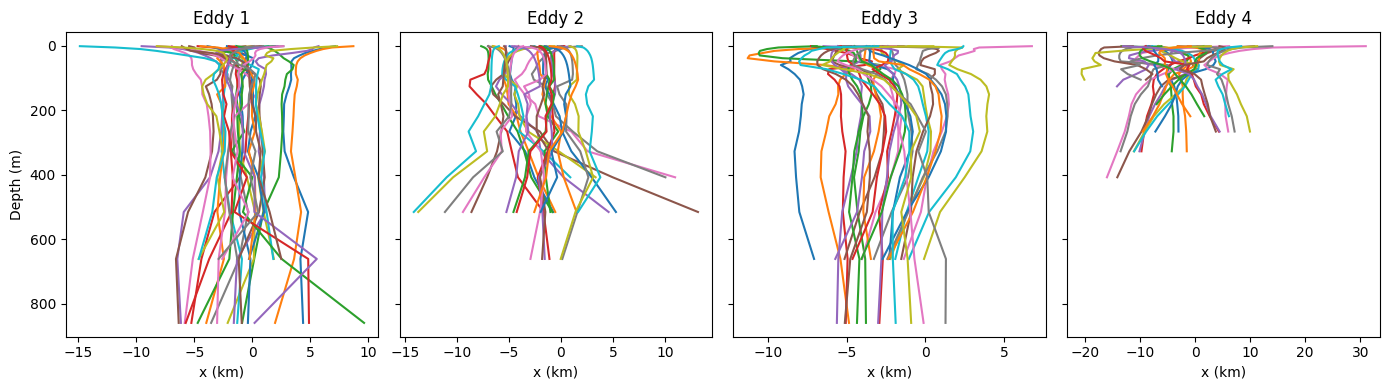

In [54]:
fig, axs = plt.subplots(1, 4, figsize=(14,4), sharey=True)

for i, eddy in enumerate(the_frontier_eddies):

    for t in range(0, 30):
    
        df = df_VG[(df_VG['Eddy']==eddy) & (df_VG['Day']==t)]
    
        axs[i].plot(df['xc'], -df['Depth'])
        axs[i].set_title(f'Eddy {i+1}')
    
    axs[i].set_xlabel('x (km)')
axs[0].set_ylabel('Depth (m)')
axs[0].invert_yaxis()

plt.tight_layout()
plt.show()

#### COW

In [10]:
def calc_ow(uu, vv, dx, dy):
    WIDTH, LENGTH, SIGMAS = uu.shape
    u_x = (uu[2:,:,:] - uu[:-2,:,:]) / (2*dx)
    u_y = (uu[:,2:,:] - uu[:,:-2,:]) / (2*dy)
    v_x = (vv[2:,:,:] - vv[:-2,:,:]) / (2*dx)
    v_y = (vv[:,2:,:] - vv[:,:-2,:]) / (2*dy)
    u_x = np.concatenate((np.zeros((1, LENGTH, SIGMAS)), u_x, np.zeros((1, LENGTH, SIGMAS))), axis=0)
    v_x = np.concatenate((np.zeros((1, LENGTH, SIGMAS)), v_x, np.zeros((1, LENGTH, SIGMAS))), axis=0)
    u_y = np.concatenate((np.zeros((WIDTH, 1, SIGMAS)), u_y, np.zeros((WIDTH, 1, SIGMAS))), axis=1)
    v_y = np.concatenate((np.zeros((WIDTH, 1, SIGMAS)), v_y, np.zeros((WIDTH, 1, SIGMAS))), axis=1)
    s_n = u_x - v_y
    s_s = v_x + u_y
    vort = v_x - u_y
    ow = s_n**2 + s_s**2 - vort**2
    return ow
    
def normalize_matrix(matrix, mask_value=np.nan):
    valid_mask = np.where(matrix == mask_value, 0, 1)
    valid_mean = np.nansum(matrix) / np.sum(valid_mask)
    valid_std = np.sqrt(np.nansum(valid_mask * (matrix - valid_mean) ** 2) / np.sum(valid_mask))
    return (matrix - valid_mean) / valid_std

In [11]:
df_COW = pd.DataFrame(columns=['Eddy', 'Day', 'xc', 'yc', 'z', 'Depth', 'SR'])

CS_THRESH = 0.1
OW_THRESH = -.2
RATIO_THRESH = 1/3
SEARCH_RADIUS_MAX = 200

for eddy in the_frontier_eddies:

    for t in range(30): 

        U = sample_data[eddy]['T'+str(t)]['U']
        V = sample_data[eddy]['T'+str(t)]['V']
        
        x, y = sample_data[eddy]['T'+str(t)]['x']/1000, sample_data[eddy]['T'+str(t)]['y']/1000
        X, Y, dx = *np.meshgrid(x, y), x[1]-x[0]
        
        CS = np.hypot(U, V)
        OW = normalize_matrix(calc_ow(U, V, dx, dx))

        bottom_flag = 0
        xc_pre, yc_pre = 0, 0
        for depth_lvl in range(25):

            Search_Radius = 10

            if bottom_flag:
                break

            u, v = U[:, :, depth_lvl], V[:,:, depth_lvl]
            cs, ow = CS[:, :, depth_lvl], OW[:, :, depth_lvl]

            R = np.hypot(X - xc_pre , Y - yc_pre).T 

            while not bottom_flag:
                        
                    mask = (cs < CS_THRESH) & (ow < OW_THRESH) & (R < Search_Radius)
                    
                    potential_centers_ind = np.array(np.where(mask)).T
                    num_pot, num_search = np.sum(mask), np.sum(R < Search_Radius)
        
                    if num_pot == 0:
                        bottom_flag = 1
                        break
                        
                    ratio = num_pot / num_search
                    if ratio <= RATIO_THRESH:
                        A = np.array([[x[i], y[j]] for i, j in potential_centers_ind])
                        xc, yc = np.mean(A, axis=0)

                        R_diff = np.hypot(xc - xc_pre, yc - yc_pre)
                        if R_diff < 100:

                            df_COW.loc[len(df_COW)] = {'Eddy': eddy, 'Day': t, 'xc': xc, 'yc': yc, 'z': depth_lvl, 'Depth': z_r[150, 150, depth_lvl], 'SR': Search_Radius}
                            xc_pre, yc_pre = xc, yc
                            break
                    
                    if Search_Radius >= SEARCH_RADIUS_MAX:
                        bottom_flag = 1
                    else:
                        Search_Radius += 5
        

In [12]:
df_COW

,Eddy,Day,xc,yc,z,Depth,SR
0,Eddy790,0,6.333333,-1.000000,0,-1.783320,10
1,Eddy790,0,6.272727,1.090909,1,-5.879627,10
2,Eddy790,0,6.000000,1.500000,2,-10.725783,10
3,Eddy790,0,5.454545,1.363636,3,-16.383097,10
4,Eddy790,0,4.500000,1.000000,4,-22.925581,15
...,...,...,...,...,...,...,...
2508,Eddy775,29,2.589744,-1.974359,15,-218.754856,35
2509,Eddy775,29,-1.008621,0.905172,16,-266.206398,35
2510,Eddy775,29,-3.670213,4.468085,17,-327.440851,30
2511,Eddy775,29,-5.240000,8.640000,18,-407.922192,30


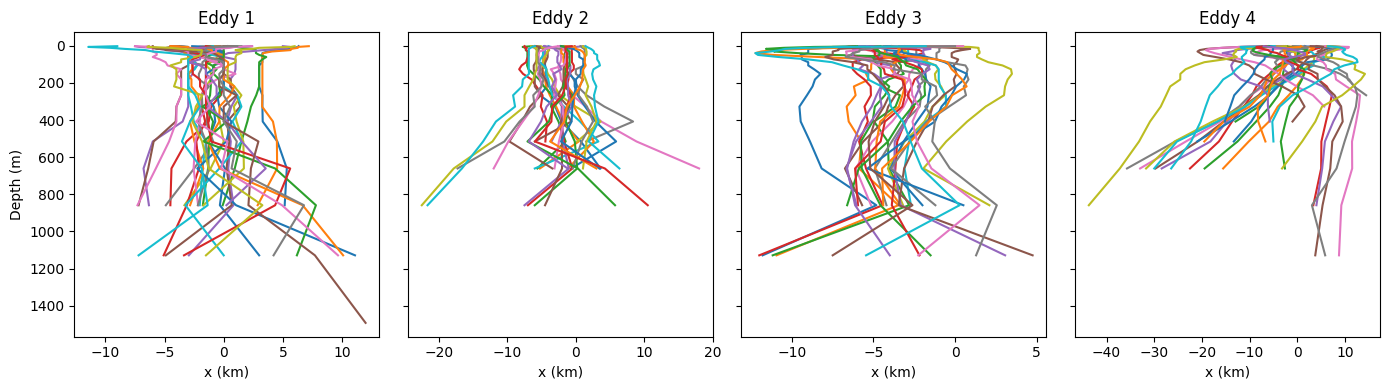

In [13]:
fig, axs = plt.subplots(1, 4, figsize=(14,4), sharey=True)

for i, eddy in enumerate(the_frontier_eddies):

    for t in range(0, 30):
    
        df = df_COW[(df_COW['Eddy']==eddy) & (df_COW['Day']==t)]
    
        axs[i].plot(df['xc'], -df['Depth'])
        axs[i].set_title(f'Eddy {i+1}')
    
    axs[i].set_xlabel('x (km)')
axs[0].set_ylabel('Depth (m)')
axs[0].invert_yaxis()

plt.tight_layout()
plt.show()

#### LNAM

In [14]:
# def calc_ow_3D(uu, vv, dx, dy):
#     WIDTH, LENGTH, SIGMAS = uu.shape
#     u_x = (uu[2:,:,:] - uu[:-2,:,:]) / (2*dx)
#     u_y = (uu[:,2:,:] - uu[:,:-2,:]) / (2*dy)
#     v_x = (vv[2:,:,:] - vv[:-2,:,:]) / (2*dx)
#     v_y = (vv[:,2:,:] - vv[:,:-2,:]) / (2*dy)
#     u_x = np.concatenate((np.zeros((1, LENGTH, SIGMAS)), u_x, np.zeros((1, LENGTH, SIGMAS))), axis=0)
#     v_x = np.concatenate((np.zeros((1, LENGTH, SIGMAS)), v_x, np.zeros((1, LENGTH, SIGMAS))), axis=0)
#     u_y = np.concatenate((np.zeros((WIDTH, 1, SIGMAS)), u_y, np.zeros((WIDTH, 1, SIGMAS))), axis=1)
#     v_y = np.concatenate((np.zeros((WIDTH, 1, SIGMAS)), v_y, np.zeros((WIDTH, 1, SIGMAS))), axis=1)
#     s_n = u_x - v_y
#     s_s = v_x + u_y
#     vort = v_x - u_y
#     ow = s_n**2 + s_s**2 - vort**2
#     return ow

def calc_lnam(x, y, uu, vv): # remember to input u and v transpose
    b, f = 1, -1
    borders = b + 1
    # L = np.zeros_like(uu)
    L = np.full_like(uu, np.nan)
    for i in range(borders, uu.shape[0] - borders):
        for j in range(borders, uu.shape[1] - borders):
            if not np.isnan(vv[i, j]):
                xlocal = x[i - b:i + b + 1, j - b:j + b + 1]
                ylocal = y[i - b:i + b + 1, j - b:j + b + 1]
                ulocal = uu[i - b:i + b + 1, j - b:j + b + 1]
                vlocal = vv[i - b:i + b + 1, j - b:j + b + 1]
                center_idx = xlocal.shape[0]//2
                d_xcentre = xlocal - xlocal[center_idx, center_idx]
                d_ycentre = ylocal - ylocal[center_idx, center_idx]
                cross = d_xcentre * vlocal - d_ycentre * ulocal
                dot = ulocal * d_xcentre + vlocal * d_ycentre
                produit = np.sqrt(ulocal**2 + vlocal**2) * np.sqrt(d_xcentre**2 + d_ycentre**2)
                sumdp = np.sum(dot) + np.sum(produit)
                if sumdp != 0:
                    L[i, j] = np.sum(cross) / sumdp * np.sign(f)
    return L


In [15]:
from scipy.ndimage import maximum_filter, minimum_filter

df_LNAM = pd.DataFrame(columns=['Eddy', 'Day', 'xc', 'yc', 'z', 'Depth'])

WINDOW_SIZE = 7
SEARCH_RADIUS = 100
VAR = 1  # 1 for cyclonic

for eddy in the_frontier_eddies:

    var = 1 if eddies[eddy].iloc[0]['Vort'] < 0 else -1

    for t in range(30): 

        U = sample_data[eddy]['T'+str(t)]['U']
        V = sample_data[eddy]['T'+str(t)]['V']
        
        x, y = sample_data[eddy]['T'+str(t)]['x']/1000, sample_data[eddy]['T'+str(t)]['y']/1000
        X, Y, dx = *np.meshgrid(x, y), x[1]-x[0]

        sigma_OW = normalize_matrix(calc_ow(U, V, dx, dx))

        xc_pre, yc_pre = 0, 0
        ic_pre, jc_pre = U.shape[0] // 2, V.shape[1] // 2
        bottom_flag = False
        for depth_lvl in range(25):
            if bottom_flag:
                break

            u, v = U[:, :, depth_lvl], V[:,:, depth_lvl]
            
            IC, JC = np.meshgrid(np.arange(u.shape[0]), np.arange(u.shape[1]))
            R = (np.hypot(ic_pre - IC, jc_pre - JC) * dx).T

            u = np.where(R <= SEARCH_RADIUS, u, np.nan)
            v = np.where(R <= SEARCH_RADIUS, v, np.nan)

            lnam = calc_lnam(X, Y, u.T, v.T).T

            if var == 1:
                extrema = maximum_filter(lnam, size=WINDOW_SIZE, mode='reflect')
            else:
                extrema = minimum_filter(lnam, size=WINDOW_SIZE, mode='reflect')

            positions = (lnam == extrema)
            ic, jc = np.argwhere(positions).T

            if len(ic):
                R = (np.hypot(ic - ic_pre, jc - jc_pre) * dx).T
                idx = np.nanargmin(R)
                ic, jc = ic[idx], jc[idx]

                R_diff = np.hypot(ic - ic_pre, jc - jc_pre) * dx
                if (sigma_OW[ic, jc, depth_lvl] <= -0.2) & (R_diff < 100):
                    df_LNAM.loc[len(df_LNAM)] = {'Eddy': eddy, 'Day': t, 'xc': x[ic], 'yc': y[jc], 'z': depth_lvl, 'Depth': z_r[150, 150, depth_lvl]}
                    xc_pre, yc_pre = xc, yc
                    ic_pre, jc_pre = ic, jc
                else:
                    bottom_flag = True
        print(t)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [16]:
df_LNAM

,Eddy,Day,xc,yc,z,Depth
0,Eddy790,0,6.0,0.0,0,-1.783320
1,Eddy790,0,6.0,0.0,1,-5.879627
2,Eddy790,0,6.0,0.0,2,-10.725783
3,Eddy790,0,6.0,0.0,3,-16.383097
4,Eddy790,0,3.0,0.0,4,-22.925581
...,...,...,...,...,...,...
2504,Eddy775,29,6.0,-3.0,13,-151.065954
2505,Eddy775,29,6.0,-3.0,14,-181.264793
2506,Eddy775,29,6.0,-3.0,15,-218.754856
2507,Eddy775,29,6.0,-3.0,16,-266.206398


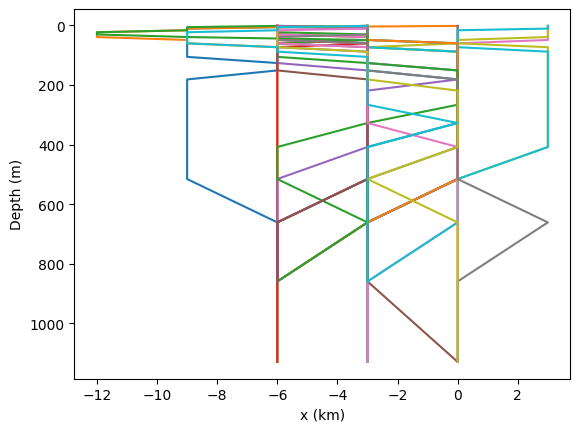

In [17]:
eddy = the_frontier_eddies[2]

for t in range(30):

    df = df_LNAM[(df_LNAM['Eddy']==eddy) & (df_LNAM['Day']==t)]

    plt.plot(df['xc'], -df['Depth'])

plt.xlabel('x (km)')
plt.ylabel('Depth (m)')
plt.gca().invert_yaxis()

### Plotted all together

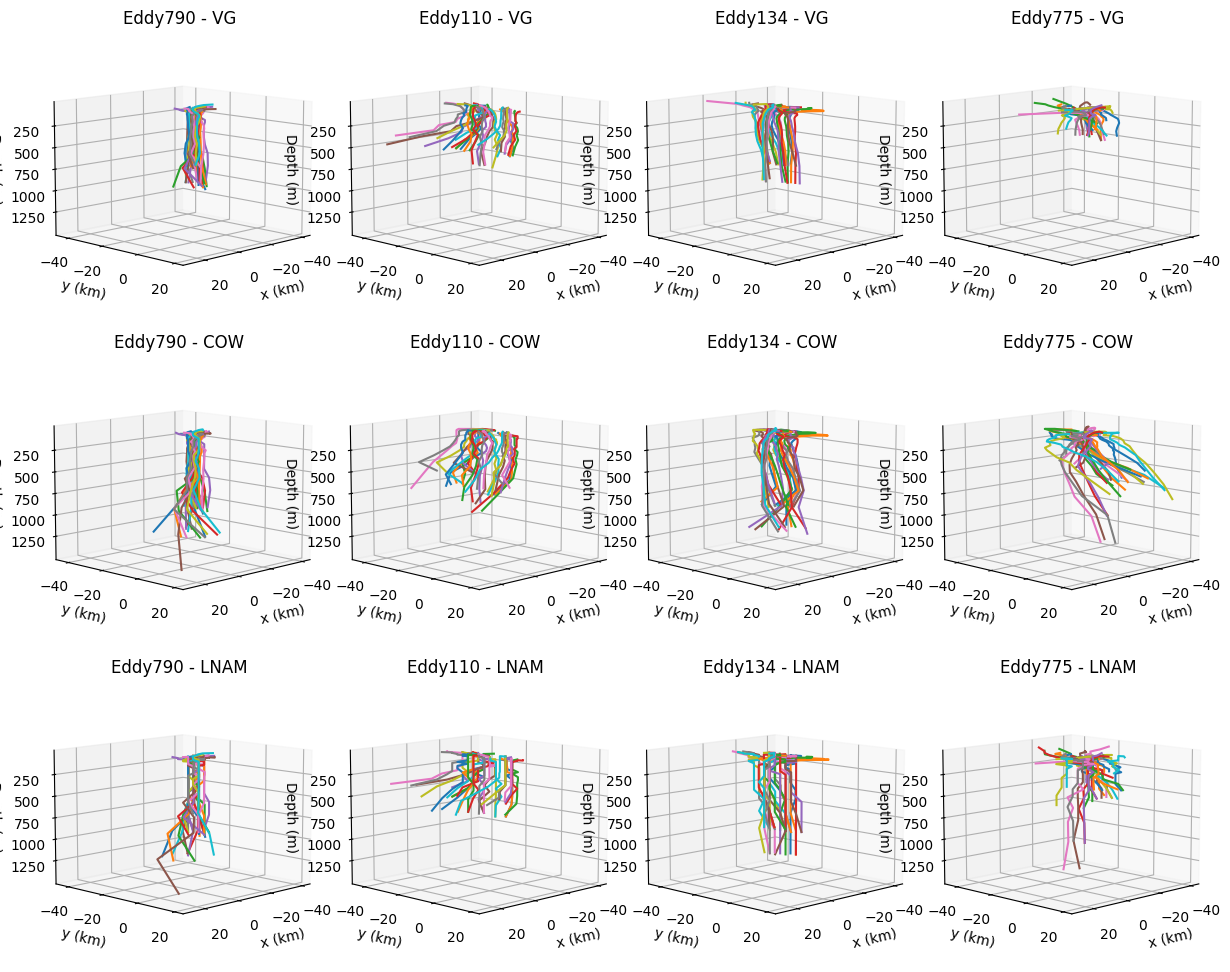

In [55]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig, axs = plt.subplots(3, len(the_frontier_eddies), figsize=(12, 10), subplot_kw={'projection': '3d'})
methods = {'VG': df_VG, 'COW': df_COW, 'LNAM': df_LNAM}

# Compute column-wise limits
limits = {eddy: (
    min(df['xc'].min() for df in methods.values() if eddy in df['Eddy'].values),
    max(df['xc'].max() for df in methods.values() if eddy in df['Eddy'].values),
    min(df['yc'].min() for df in methods.values() if eddy in df['Eddy'].values),
    max(df['yc'].max() for df in methods.values() if eddy in df['Eddy'].values),
    -max(df['Depth'].max() for df in methods.values() if eddy in df['Eddy'].values),
    -min(df['Depth'].min() for df in methods.values() if eddy in df['Eddy'].values),
) for eddy in the_frontier_eddies}

# Plot data
for r, (method, df_method) in enumerate(methods.items()):
    for c, eddy in enumerate(the_frontier_eddies):
        ax = axs[r, c]
        for t in range(30):
            df = df_method[(df_method['Eddy'] == eddy) & (df_method['Day'] == t)]
            ax.plot(df['xc'], df['yc'], -df['Depth'])

        ax.set(xlim=limits[eddy][:2], ylim=limits[eddy][2:4], zlim=limits[eddy][4:],
               xlabel="x (km)", ylabel="y (km)", zlabel="Depth (m)", title=f"{eddy} - {method}")
        ax.invert_zaxis()
        ax.view_init(elev=10, azim=45)

plt.tight_layout()
plt.show()


In [56]:
df_VG

,Eddy,Day,xc,yc,nic,njc,z,Depth,w
0,Eddy790,0,7.133481,-0.581158,49,49,0,-1.783320,0.037167
1,Eddy790,0,6.372685,0.285363,51,49,1,-5.879627,0.036798
2,Eddy790,0,5.809128,0.756879,51,49,2,-10.725783,0.036525
3,Eddy790,0,5.197180,1.021586,51,49,3,-16.383097,0.036318
4,Eddy790,0,4.551339,1.080637,51,49,4,-22.925581,0.036093
...,...,...,...,...,...,...,...,...,...
2331,Eddy775,29,3.730977,-2.416898,51,48,11,-105.615538,-0.012985
2332,Eddy775,29,4.223554,-2.570736,50,48,12,-126.288127,-0.012553
2333,Eddy775,29,5.003580,-3.008361,50,48,13,-151.065954,-0.012086
2334,Eddy775,29,5.470478,-3.148775,51,48,14,-181.264793,-0.011323


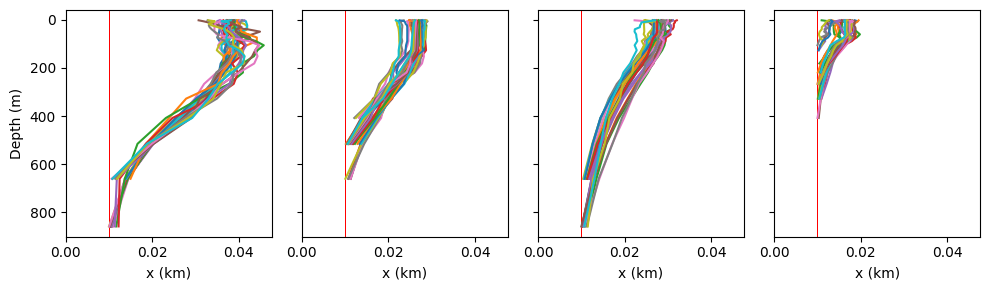

In [58]:
fig, axs = plt.subplots(1, 4, figsize=(10, 3), sharey=True)

for e, eddy in enumerate(the_frontier_eddies):

    
    for t in range(30):
    
        df = df_VG[(df_VG['Eddy']==eddy) & (df_VG['Day']==t)]
    
        axs[e].plot(np.abs(df['w']), -df['Depth'])

        axs[e].axvline(x=0.01, color='r', zorder=-1, linewidth=.5, alpha=.5)
    
    axs[e].set_xlabel('x (km)')

xmax = 0
for ax in axs:
    xmax= max(xmax, ax.get_xlim()[1])
for ax in axs:
    ax.set_xlim(0, xmax)

    
axs[0].invert_yaxis()
axs[0].set_ylabel('Depth (m)')

plt.tight_layout()
plt.show()